In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%config InlineBackend.figure_format = 'svg'

In [2]:
DATA_DIR = '../../datasets'

df = pd.read_csv(f'{DATA_DIR}/pan15_semicleaned.tsv', sep='\t', encoding='utf-8')
df.sample(5)

,author,gender,age_group,extroverted,stable,agreeable,conscientious,open,documents,semicleaned,tokenized,pos_fw
3041,6a3addbf,F,25-34,0.4,0.5,0.2,0.2,0.2,Ho Ho Ho! Merry Christmas! \n???? ???? ???? ??...,ho ho ho! merry christmas! ? ? ? ?,ho ho ho ! merry christmas ! ? ? ? ?,PROPN PROPN PROPN ! VERB PROPN ! ? ? ? ?
12973,b90df535,M,25-34,0.0,0.4,-0.2,0.5,0.5,#wcpr13 @username #icwsm: 8 teams participatin...,: 0 teams participating in the shared task. r...,: 0 team participate in the share task . res...,SPACE : NUM NOUN VERB in the NOUN NOUN . NOUN ...
3261,bb414002,M,18-24,0.2,0.1,-0.2,0.0,0.2,Nobody knows I'm a lesbian http://t.co/x8VFMlL...,nobody knows i'm a lesbian,nobody know I be a lesbian,nobody VERB I be a NOUN
9064,0aa7bace,M,35-49,0.1,0.3,0.3,0.2,0.4,ohhh look me and @username presenting at @user...,ohhh look me and presenting at 0000 ;-),ohhh look I and present at 0000 ;-),ADJ VERB I and ADJ at NUM ;-)
9631,1ed443b9,M,50-XX,0.3,-0.1,-0.1,0.0,-0.1,"""the madness is coming to an end. VCs are shyi...","""the madness is coming to an end. vcs are shyi...",""" the madness be come to an end . vcs be shy a...",""" the NOUN be VERB to an NOUN . NOUN be ADJ AD..."


In [3]:
len(df.groupby('author'))

152

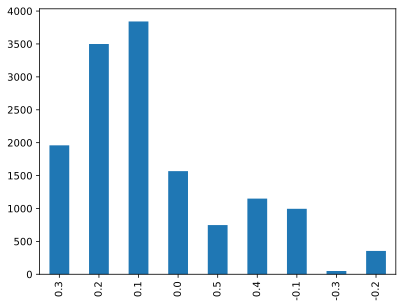

In [4]:
df['extroverted'].value_counts(sort=False, ascending=True).plot(kind='bar');

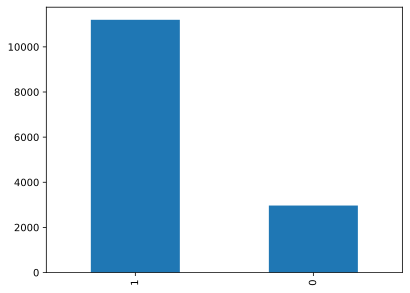

In [5]:
# Convert to binary: if the score is >0, then the author is extroverted, otherwise introverted
df['extroverted'] = df['extroverted'].apply(lambda x: 1 if x > 0 else 0)
df['extroverted'].value_counts(sort=False, ascending=True).plot(kind='bar');

In [6]:
# Calculate the weights for each class
class_weights = dict(df['extroverted'].value_counts(normalize=True))
class_weights = {k: round(1-v, 3) for k, v in class_weights.items()}
class_weights

{1: 0.209, 0: 0.791}

In [7]:
X = df['tokenized']
y = df['extroverted']

# Use GroupShuffleSplit to split the data into train and test sets while keeping the authors in the same set
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=df['author']))
X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11202,), (2964,), (11202,), (2964,))

In [8]:
vect = TfidfVectorizer()
svm = LinearSVC(random_state=97)

pipe = make_pipeline(vect, svm)

In [9]:
param_grid = {
    'tfidfvectorizer__analyzer': ['word', 'char'],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'linearsvc__class_weight': [class_weights]
}

In [10]:
gs = GridSearchCV(pipe, param_grid, cv=10, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
{'linearsvc__class_weight': {1: 0.209, 0: 0.791}, 'tfidfvectorizer__analyzer': 'word', 'tfidfvectorizer__ngram_range': (1, 4)}


In [11]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.30      0.32       690
           1       0.79      0.82      0.81      2274

    accuracy                           0.70      2964
   macro avg       0.56      0.56      0.56      2964
weighted avg       0.69      0.70      0.69      2964



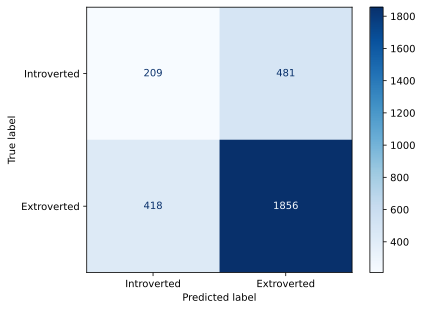

In [12]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = ['Introverted', 'Extroverted']
disp.plot(cmap='Blues');

## Add other features

### Other personality traits + POS tags and function words

In [13]:
X = df[['tokenized', 'pos_fw', 'stable', 'agreeable', 'conscientious', 'open']]
y = df['extroverted']

# Use GroupShuffleSplit to split the data into train and test sets while keeping the authors in the same set
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=df['author']))
X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11202, 6), (2964, 6), (11202,), (2964,))

In [14]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class RowIterator(TransformerMixin):
    """ Prepare Series for DictVectorizer """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        from ast import literal_eval
        return X.apply(literal_eval)

In [15]:
from sklearn.pipeline import make_pipeline

word_pipe = Pipeline([
    ('selector', ItemSelector(key='tokenized')),
    ('vect', TfidfVectorizer(analyzer='word'))
])

pos_pipe = Pipeline([
    ('selector', ItemSelector(key='pos_fw')),
    ('vect', TfidfVectorizer(analyzer='word'))
])
   
num_pipe = Pipeline([
    ('selector', ItemSelector(key=['stable', 'agreeable', 'conscientious', 'open']))
])

pipe = Pipeline([
    ('feats', FeatureUnion([  
            ('word', word_pipe),
            ('pos_fw', pos_pipe),
            ('num', num_pipe),
        ],
    )),
    ('clf', LinearSVC(random_state=97, class_weight=class_weights))
])

In [16]:
param_grid = {
    'feats__word__vect__ngram_range': [(1, 2), (1, 3)],
    'feats__pos_fw__vect__ngram_range': [(1, 2), (1, 3)],
}

In [17]:
gs = GridSearchCV(pipe, param_grid, cv=10, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)
 
gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
{'feats__pos_fw__vect__ngram_range': (1, 3), 'feats__word__vect__ngram_range': (1, 3)}


In [18]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.45      0.53       690
           1       0.85      0.92      0.88      2274

    accuracy                           0.81      2964
   macro avg       0.74      0.69      0.70      2964
weighted avg       0.80      0.81      0.80      2964



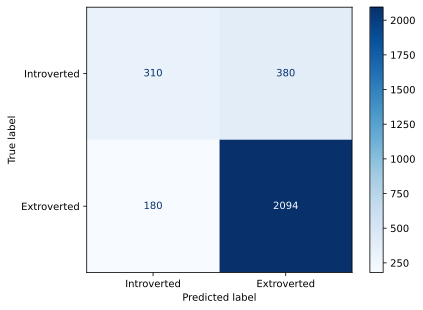

In [19]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = ['Introverted', 'Extroverted']
disp.plot(cmap='Blues');

### LIWC features

In [20]:
from __future__ import division
from __future__ import print_function

import re

from codecs import open
from collections import Counter


class DictFeaturizer(object):
    def __init__(self, dictionary, relative=True):
        self.dict = {}
        self.rel = relative
        matcher = re.compile(r'([\*\+])')

        for key, words in dictionary.items():

            normal = {x for x in words if not matcher.findall(x)}
            regexstring = "|".join([matcher.sub(r'\\w\1', x)
                                    for x in words if x not in normal])

            if regexstring:
                wildcards = re.compile(regexstring)
            else:
                wildcards = None

            self.dict[key] = (normal, wildcards)

    def transform(self, tokens):
        # Make frequency dictionary of the text to diminish number
        # of runs in further for loop
        freq_dict = Counter(tokens)
        features = dict()

        for key, wordlists in self.dict.items():

            normal, wildcards = wordlists

            keys = set(freq_dict.keys())

            features[key] = sum([freq_dict[k] for k in normal & keys])
            if wildcards:
                features[key] += sum([freq_dict[k] for k in keys - normal
                                      if wildcards.match(k)])

        if self.rel:
            return {k: v / len(tokens) for k, v in features.items()}
        else:
            return features

    @staticmethod
    def load(path, relative=True):
        d = {}
        with open(path, "r", encoding='utf-8') as f:
            for line in f:
                line = line.lower().strip().split(",")
                key, words = line[0], set(line[1:])
                d[key] = words

        return DictFeaturizer(d, relative=relative)


In [21]:
liwc = DictFeaturizer.load("../../datasets/LIWC/LIWC_English.csv")

In [22]:
df = df.assign(liwc=df['tokenized'].apply(liwc.transform))
df.sample(5)

,author,gender,age_group,extroverted,stable,agreeable,conscientious,open,documents,semicleaned,tokenized,pos_fw,liwc
12711,1f17c4c3,M,18-24,0,0.2,0.1,0.0,0.2,I just want a good girl who will be bad just f...,i just want a good girl who will be bad just f...,I just want a good girl who will be bad just f...,I just VERB a ADJ NOUN who will be ADJ just for I,"{'funct': 0.1, 'pronoun': 0.04, 'ppron': 0.04,..."
12429,4b05f4e0,F,18-24,1,0.0,0.3,0.3,0.4,@username thank you so much!\t\t,thank you so much!,thank you so much !,SPACE VERB you so much !,"{'funct': 0.047619047619047616, 'pronoun': 0.0..."
6429,e27e308c,F,35-49,1,0.3,0.2,0.4,0.5,Change Your Life: ItWorks! CEO on 'Re-Dreaming...,change your life: itworks! ceo on 're-dreaming...,change your life : itwork ! ceo on 're - dream...,VERB your NOUN : NOUN ! NOUN on 're - NOUN ' -...,"{'funct': 0.13793103448275862, 'pronoun': 0.06..."
6381,e27e308c,F,35-49,1,0.3,0.2,0.4,0.5,*GIVE AWAY* Enter for Your Chance to Win http:...,*give away* enter for your chance to win,* give away * enter for your chance to win,* give ADP * VERB for your NOUN to VERB,"{'funct': 0.11904761904761904, 'pronoun': 0.04..."
1230,8f04a1f5,M,25-34,1,0.5,0.1,0.2,0.2,@username friends of who earn this U$D6 trillo...,friends of who earn this u$d0 trillon? there ...,friend of who earn this u$d0 trillon ? there...,SPACE NOUN of who VERB this ADJ NOUN ? there y...,"{'funct': 0.0875, 'pronoun': 0.05, 'ppron': 0...."


In [24]:
liwc_df = df['liwc'].apply(pd.Series).fillna(0).add_prefix('liwc_')
df = pd.concat([df, liwc_df], axis=1).drop(['liwc'], axis=1)
df.shape

(14166, 76)

In [28]:
from sklearn.pipeline import make_pipeline

word_pipe = Pipeline([
    ('selector', ItemSelector(key='tokenized')),
    ('vect', TfidfVectorizer(analyzer='word'))
])

pos_pipe = Pipeline([
    ('selector', ItemSelector(key='pos_fw')),
    ('vect', TfidfVectorizer(analyzer='word'))
])

num_cols = ['stable', 'agreeable', 'conscientious', 'open'] + \
           [col for col in X.columns if col.startswith('liwc_')]

num_pipe = Pipeline([
    ('selector', ItemSelector(key=num_cols))
])

pipe = Pipeline([
    ('feats', FeatureUnion([  
            ('word', word_pipe),
            ('pos_fw', pos_pipe),
            ('num', num_pipe),
        ],
    )),
    ('clf', LinearSVC(random_state=97, class_weight=class_weights))
])

In [29]:
gs = GridSearchCV(pipe, param_grid, cv=10, scoring='f1_macro', n_jobs=-1, refit=True, verbose=5)

gs.fit(X_train, y_train)
print(gs.best_params_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
{'feats__pos_fw__vect__ngram_range': (1, 3), 'feats__word__vect__ngram_range': (1, 3)}


In [30]:
y_pred = gs.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.45      0.53       690
           1       0.85      0.92      0.88      2274

    accuracy                           0.81      2964
   macro avg       0.74      0.69      0.70      2964
weighted avg       0.80      0.81      0.80      2964



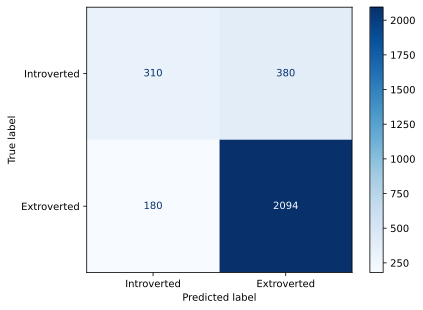

In [31]:
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.display_labels = ['Introverted', 'Extroverted']
disp.plot(cmap='Blues');